In [1]:
import csv
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.optim as optim
import numpy as np

from tqdm.auto import tqdm
from pathlib import Path
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"

BATCH_SIZE = 16
IMAGE_SHAPE = (128, 128)
PROCESSED_DATASET_PATH_MNETV1_TRAIN = Path("../../../dataset/processed/train")
PROCESSED_DATASET_PATH_MNETV1_TEST = Path("../../../dataset/processed/test/")
PROCESSED_DATASET_PATH_MNETV1_VAL = Path("../../../dataset/processed/val")


print(device)

cuda:0


In [2]:
train_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transform = transforms.Compose([
    transforms.Resize(IMAGE_SHAPE),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

train_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_TRAIN, transform=train_transform)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_VAL, transform=test_transform)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

test_set = datasets.ImageFolder(PROCESSED_DATASET_PATH_MNETV1_VAL, transform=test_transform)
test_loader = DataLoader(test_set, shuffle=True)

print(len(train_set), len(val_set), len(test_set), train_set.classes)

10805 1346 1346 ['antelope', 'cow', 'deer', 'elephant', 'giraffe', 'horse', 'lion', 'rabbit', 'sheep', 'squirrel', 'zebra']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


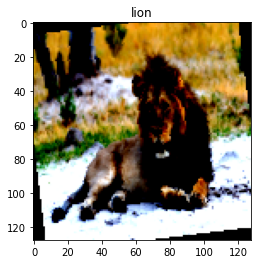

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


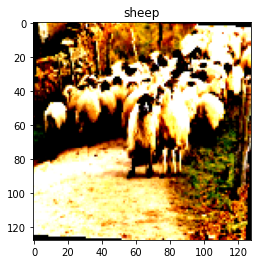

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


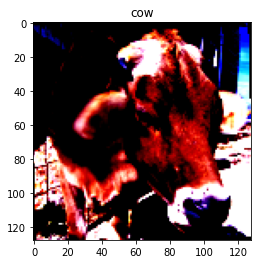

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


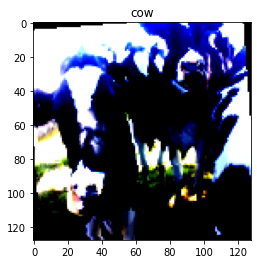

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


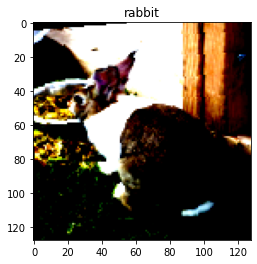

In [3]:
train_loader_vis = torch.utils.data.DataLoader(train_set, 15, shuffle=True)

images, labels = next(iter(train_loader_vis))
images, labels = images.numpy() , labels.numpy()

for i in range(5):
    plt.imshow(np.transpose(images[i] , (1,2,0)))
    plt.title(train_set.classes[labels[i]])
    plt.show()

del images, labels
del train_loader_vis

In [4]:
model = torchvision.models.vgg11(num_classes=len(train_set.classes), weights=None)
model = model.to(device)
model.eval()

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): ReLU(inplace=True)
    (13): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14): ReLU(inplace=True)
    (15): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
 

In [5]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [6]:
open("./logs/training_logs.csv", "w", newline="")
log_file = open("./logs/training_logs.csv", "a", newline="")
csv_writer = csv.writer(log_file)
csv_writer.writerow(["epoch", "train_loss", "train_acc", "val_loss", "val_acc"])


def loop_fn(mode, dataset, dataloader, model, criterion, optimizer):
    if mode == 'train':
        model.train()
    elif mode == 'val':
        model.eval()
  
    loss = correct = 0
    for feature, target in tqdm(dataloader, desc=mode.title()):
        feature, target = feature.to(device), target.to(device)
        output = model(feature)
        loss = criterion(output, target)

        if mode == 'train':
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        loss += loss.item() * feature.shape[0]
        correct += (output.argmax(1) == target).sum().item()
    loss = loss/len(dataset)
    accuracy = correct/len(dataset)
    return loss, accuracy

num_epochs = 10
try:
    for epoch in range(1, num_epochs + 1):
        train_cost, train_score = loop_fn('train', train_set, train_loader, model, criterion, optimizer)
        with torch.no_grad():
            test_cost, test_score = loop_fn('val', val_set, val_loader, model, criterion, optimizer)
        print(epoch, float(train_cost), train_score, float(test_cost), test_score)
        csv_writer.writerow([epoch, float(train_cost), train_score, float(test_cost), test_score])
        torch.save(model.state_dict(), f"./logs/models/model_e{epoch}.pth")
except Exception as e:
    log_file.close()
    raise e


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

1 0.0013920225901529193 0.1042110134197131 0.005583670921623707 0.12184249628528974


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

2 0.0012487528147175908 0.11883387320684868 0.005523496773093939 0.12184249628528974


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

3 0.0012721549719572067 0.11772327626099029 0.005092869512736797 0.12184249628528974


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

4 0.0013478766195476055 0.11948172142526609 0.005529496353119612 0.12184249628528974


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

5 0.0013048802502453327 0.11689032855159648 0.005755651742219925 0.12184249628528974


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

6 0.0013558368664234877 0.12096251735307728 0.005337192211300135 0.12184249628528974


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

7 0.0012607108801603317 0.12049976862563629 0.005528521724045277 0.12184249628528974


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

8 0.001401736051775515 0.12161036557149468 0.005545540247112513 0.12184249628528974


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

9 0.0012881974689662457 0.12161036557149468 0.0057355123572051525 0.12184249628528974


Train:   0%|          | 0/676 [00:00<?, ?it/s]

Val:   0%|          | 0/85 [00:00<?, ?it/s]

10 0.0013129513245075941 0.12207311429893568 0.005463369190692902 0.0988112927191679


In [9]:
with torch.no_grad():
    test_cost, test_score = loop_fn('val', test_set, test_loader, model, criterion, optimizer)
print(f"Testing Loss = {test_cost}, Accuracy = {test_score}")

Val:   0%|          | 0/1346 [00:00<?, ?it/s]

Testing Loss = 0.0033248707186430693, Accuracy = 0.0988112927191679


In [10]:

y_pred = []
y_true = []

test_loader2 = DataLoader(test_set, shuffle=True)
for images, labels in test_loader2:
        output = np.squeeze(model(images.cuda()).data.max(1, keepdim=True)[1].cpu().numpy())
        y_pred.extend([output])
        
        labels = labels.data.cpu().numpy()
        y_true.extend([labels])

from sklearn.metrics import accuracy_score, classification_report


print("Overall Accuracy: ", round(accuracy_score(y_true, y_pred)*100,2)," %")
print(classification_report(y_true, y_pred,target_names=train_set.classes))

Overall Accuracy:  9.88  %
              precision    recall  f1-score   support

    antelope       0.00      0.00      0.00       104
         cow       0.10      1.00      0.18       133
        deer       0.00      0.00      0.00       134
    elephant       0.00      0.00      0.00       103
     giraffe       0.00      0.00      0.00       120
       horse       0.00      0.00      0.00       164
        lion       0.00      0.00      0.00       101
      rabbit       0.00      0.00      0.00       108
       sheep       0.00      0.00      0.00       142
    squirrel       0.00      0.00      0.00       120
       zebra       0.00      0.00      0.00       117

    accuracy                           0.10      1346
   macro avg       0.01      0.09      0.02      1346
weighted avg       0.01      0.10      0.02      1346



c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\Deep Raval\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_